In [187]:
import os 
import pickle 
import numpy as np
import matplotlib.pylab as plt 
from getdist import plots, MCSamples
from typing import Any
from numpyro.diagnostics import summary, effective_sample_size, autocovariance

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 15

settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3}
color1 = '#50C878' #'#B5CA8D'
color3 = '#222E50'
alpha = 0.5
palefactor = 0.9
linewidth = 2 
contours = [0.68,0.95]

In [5]:
def triangle_plot(mcmc_samples, labels, subplot_size = 2, font_size = 18, fname = None):
    ndim = len(labels)
    colour = 'green'
    names = ["x%s"%i for i in range(ndim)]
    samples = MCSamples(samples=mcmc_samples,names = names, labels = labels, settings = settings)
    
    G = plots.getSubplotPlotter(subplot_size=subplot_size)
    samples.updateSettings({'contours': contours})
    G.settings.solid_contour_palefactor = 0.9
    G.settings.alpha_filled_add = 0.6
    G.settings.num_plot_contours = 2
    G.triangle_plot(samples, filled = True, line_args={'lw':linewidth, 'color':colour}, contour_colors=[colour])
    
    for i in range(0,ndim):
        for j in range(0, i+1):
            if i != j:
                ax = G.subplots[i,j]

                a, b = G.get_param_array(samples, ['x'+str(j), 'x'+str(i)])
                density = G.sample_analyser.get_density_grid(samples, a, b)
                density.contours = density.getContourLevels(contours)
                contour_levels = density.contours

                ax.contour(density.x, density.y, density.P, sorted(contour_levels), colors = colour, linewidths = linewidth) 
                ax.tick_params(axis = 'x', labelsize = font_size, rotation=45, pad=5)
                ax.tick_params(axis = 'y', labelsize = font_size, pad=5)
                ax.yaxis.label.set_size(font_size)
                ax.xaxis.label.set_size(font_size)
                ax.xaxis.labelpad = 20
                ax.yaxis.labelpad = 20
            else:
                ax = G.subplots[i,j]   

                dense = samples.get1DDensity('x'+str(i))
                dense.normalize(by='max')
                ax.plot(dense.x, dense.P, lw = linewidth+2, c = colour)

                ax.tick_params(axis = 'x', labelsize = font_size, rotation=45, pad=5)
                ax.tick_params(axis = 'y', labelsize = font_size, pad=5)
                ax.yaxis.label.set_size(font_size)
                ax.xaxis.label.set_size(font_size)
                ax.xaxis.labelpad = 20
                ax.yaxis.labelpad = 20
    if fname is not None:
        os.makedirs('plots', exist_ok=True)
        plt.savefig(f'plots/triangle_plot_{fname}.pdf', bbox_inches = 'tight')
    plt.close()

In [6]:
def pickle_load(folder: str, fname: str) -> Any:
    """Reads a list from a folder.
    Args:
        folder_name (str): The name of the folder.
        file_name (str): The name of the file.
    Returns:
        Any: sampler, list or dataframe
    """
    path = os.path.join(folder, fname)
    with open(path + ".pkl", "rb") as dummy:
        file = pickle.load(dummy)
    return file

In [7]:
labels = [r'$\sigma_{8}$', r'$\Omega_{c}$', r'$\Omega_{b}$', r'$h$', r'$n_{s}$',
          r'$m_{1}$', r'$m_{2}$', r'$m_{3}$', r'$m_{4}$', 
          r'$\delta z_{1}^{(s)}$', r'$\delta z_{2}^{(s)}$', r'$\delta z_{3}^{(s)}$', r'$\delta z_{4}^{(s)}$',
          r'$A_{IA}$', r'$\eta$', r'$b_{1}$', r'$b_{2}$', r'$b_{3}$', r'$b_{4}$', r'$b_{5}$',
         r'$\delta z_{1}^{(g)}$', r'$\delta z_{2}^{(g)}$', r'$\delta z_{3}^{(g)}$', r'$\delta z_{4}^{(g)}$', r'$\delta z_{5}^{(g)}$']

In [8]:
labels_cosmo = labels[0:5]
labels_multiplicative = labels[5:9]
labels_shift_shear = labels[9:13]
labels_intrinsic = labels[13:15]
labels_bias = labels[15:20]
labels_shift_galaxy = labels[20:]

In [9]:
def emcee_lnpost(parameters):
    pass

In [10]:
# sampler = pickle_load('samples', 'samples_emu_50_5000_2')
# flat_samples = sampler.get_chain(discard=100, thin=2, flat=True) # sampler.flatchain # 
# flat_lnprob = sampler.get_log_prob(discard=100, thin=2, flat=True)

# Compare Diagnostics

In [135]:
import arviz as az
import pandas as pd

In [13]:
sampler_jc_emcee_1 = pickle_load('samples', 'jaxcosmo_emcee_1')
sampler_jc_emcee_2 = pickle_load('samples', 'jaxcosmo_emcee_2')

In [48]:
# sampler_jc_nuts_1 = pickle_load('samples', 'jaxcosmo_nuts_1')
sampler_jc_nuts_2 = pickle_load('samples', 'jaxcosmo_nuts_2')

In [183]:
sampler_jc_nuts_2.get_extra_fields()['diverging'].sum()

DeviceArray(5470, dtype=int64)

In [197]:
sampler_jc_nuts_2.get_extra_fields(group_by_chain=True)['num_steps']

DeviceArray([[15, 31, 31, ..., 15, 15, 31],
             [21, 31, 10, ..., 16, 31, 31]], dtype=int64)

In [201]:
2**8

256

In [64]:
neval_emcee = 2 * 10000 * 25 * 2
neval_nuts = sampler_jc_nuts_2.get_extra_fields(group_by_chain=True)['num_steps'].sum(1).sum(0).item()

In [90]:
scaled_neff_nuts = summary(sampler_jc_nuts_2.get_samples(group_by_chain=True)['sigma8'])['Param:0']['n_eff'] / neval_nuts

In [177]:
thinning_factor = np.arange(1, 31, 1)
rec_n_eff_emcee = list()
rec_nemcee = list()
for t in thinning_factor:
    jc_emcee_1_sigma_8 = sampler_jc_emcee_1.get_chain(discard=1000, thin=t, flat=True)[:,0]
    jc_emcee_2_sigma_8 = sampler_jc_emcee_2.get_chain(discard=1000, thin=t, flat=True)[:,0]
    nemcee = 2 * jc_emcee_1_sigma_8.shape[0]
    n_eff_emcee = summary(np.vstack([jc_emcee_1_sigma_8, jc_emcee_2_sigma_8]))['Param:0']['n_eff'] / neval_emcee
    rec_n_eff_emcee.append(n_eff_emcee)
    rec_nemcee.append(nemcee)
rec_n_eff_emcee = np.asarray(rec_n_eff_emcee)
rec_nemcee = np.asarray(rec_nemcee)

In [178]:
az.summary(np.vstack([jc_emcee_1_sigma_8, jc_emcee_2_sigma_8]))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.83,0.063,0.715,0.949,0.0,0.0,21908.0,27304.0,1.01


In [179]:
pd.DataFrame(summary(np.vstack([jc_emcee_1_sigma_8, jc_emcee_2_sigma_8]))['Param:0'], index=[0])

,mean,std,median,5.0%,95.0%,n_eff,r_hat
0,0.83015,0.062537,0.828581,0.72527,0.933061,23122.479382,1.005924


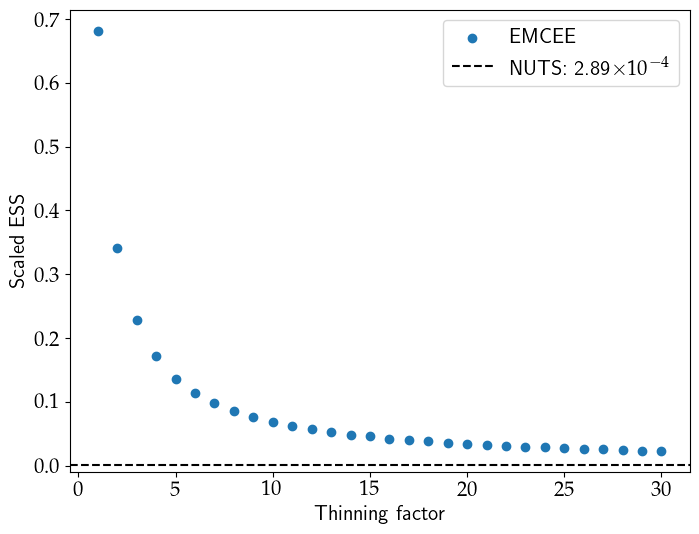

In [180]:
plt.figure(figsize = (8, 6))
plt.scatter(thinning_factor, rec_n_eff_emcee, label = 'EMCEE')
plt.axhline(scaled_neff_nuts, label = 'NUTS: ' + f'{scaled_neff_nuts * 10000:.2f}' + r'$\times 10^{-4}$', c = 'k', linestyle = '--')
plt.ylabel('Scaled ESS', fontsize = fontSize)
plt.xlabel('Thinning factor', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

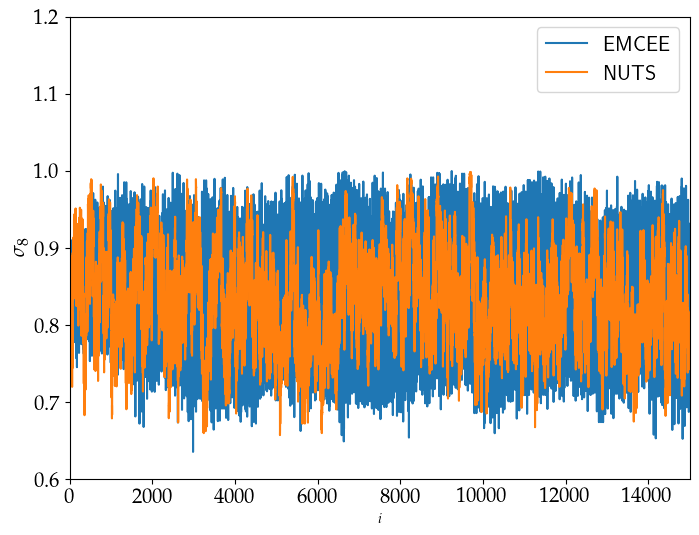

In [181]:
plt.figure(figsize = (8, 6))
plt.plot(jc_emcee_1_sigma_8, label = 'EMCEE')
plt.plot(sampler_jc_nuts_2.get_samples(group_by_chain=True)['sigma8'][0], label = 'NUTS')
plt.ylabel(r'$\sigma_{8}$', fontsize = fontSize)
plt.xlabel(r'$i$')
plt.ylim(0.6, 1.2)
plt.xlim(0, 15000)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

## CCL

In [8]:
sampler_1 = pickle_load('samples', 'cclemcee_camb_1')
sampler_2 = pickle_load('samples', 'cclemcee_camb_2')

In [10]:
ccl_samples_1 = sampler_1.get_chain(discard=100, thin=2, flat=True)
ccl_samples_2 = sampler_2.get_chain(discard=100, thin=2, flat=True)

In [12]:
ccl_cosmo = np.vstack([ccl_samples_1[:,0:5], ccl_samples_2[:,0:5]])

In [13]:
# triangle_plot(ccl_cosmo, labels_cosmo, subplot_size = 2, font_size = 18, fname = 'cosmo_emcee_ccl')

Removed no burn in


Summary statistics

In [21]:
from numpyro.diagnostics import summary
import pandas as pd

In [22]:
def ccl_emcee_stats(samples_1, samples_2):

    keys = ['sigma8', 'Omegac', 'Omegab', 'hubble', 'ns',
            'm1', 'm2', 'm3', 'm4',
            'dz_wl_1', 'dz_wl_2', 'dz_wl_3', 'dz_wl_4',
            'a_ia', 'eta',
            'b1', 'b2', 'b3', 'b4', 'b5', 
            'dz_gc_1', 'dz_gc_2', 'dz_gc_3', 'dz_gc_4', 'dz_gc_5']

    record = []
    for i, key in enumerate(keys):
        testsamples = np.vstack(([samples_1[:,i], samples_2[:,i]]))
        summary_stats = summary(testsamples)
        summary_stats[key] = summary_stats.pop('Param:0')
        record.append(summary_stats)

    record_df = []
    for i in range(len(record)):
        record_df.append(pd.DataFrame(record[i]).round(3).loc[['r_hat', 'n_eff', 'mean', 'std']])

    record_df = pd.concat(record_df, axis = 1).T
    return record_df

In [23]:
ccl_emcee_stats(ccl_samples_1, ccl_samples_2)

,r_hat,n_eff,mean,std
sigma8,1.017,176.136,0.821,0.062
Omegac,1.007,829.568,0.235,0.026
Omegab,1.003,414421.275,0.046,0.007
hubble,1.002,431621.526,0.708,0.048
ns,1.005,427951.220,0.953,0.054
m1,1.002,10168.659,0.012,0.023
m2,1.013,139.675,0.013,0.029
m3,1.023,158.050,0.015,0.025
m4,1.022,77.651,0.003,0.029
dz_wl_1,1.002,451156.692,-0.003,0.015


# Nested Sampling

In [27]:
ns_samples_1 = pickle_load('samples', 'samples_ns_jaxcosmo_1')

In [29]:
# triangle_plot(ns_samples_1.samples[:,0:5], labels_cosmo, subplot_size = 2, font_size = 18, fname = 'cosmo_ns_jaxcosmo')

Removed no burn in


## NUTS

In [14]:
cosmokeys = ['sigma8', 'Omegac', 'Omegab', 'hubble', 'ns']
emulator_samples_nuts = pickle_load('samples', 'samples_emulator_nuts_1')
jaxcosmo_samples_nuts = pickle_load('samples', 'samples_jaxcosmo_nuts_1')

emu_cosmo_samples_nuts = np.vstack([emulator_samples_nuts[key] for key in cosmokeys]).T
jax_cosmo_samples_nuts = np.vstack([jaxcosmo_samples_nuts[key] for key in cosmokeys]).T

In [15]:
emulator_samples = pickle_load('samples', 'samples_emcee_emulator')
jaxcosmo_samples = pickle_load('samples', 'samples_emcee_jaxcosmo')

emu_cosmo_samples = emulator_samples[:,0:5]
jax_cosmo_samples = jaxcosmo_samples[:,0:5]

In [10]:
# triangle_plot(emu_cosmo_samples, labels_cosmo, subplot_size = 2, font_size = 18, fname = 'cosmo_emcee_emulator')
# triangle_plot(jax_cosmo_samples, labels_cosmo, subplot_size = 2, font_size = 18, fname = 'cosmo_emcee_jaxcosmo')

Removed no burn in
Removed no burn in


# $\Omega_{m}$ vs $S_{8}$

In [11]:
# omega_matter = samples[:,1] + samples[:,2]
# s8_parameter = samples[:,0] * np.sqrt(omega_matter/0.3)
# samples_om_s8 = np.c_[np.atleast_2d(omega_matter).T, np.atleast_2d(s8_parameter).T]

omega_matter = emu_cosmo_samples[:,1] + emu_cosmo_samples[:,2]
s8_parameter = emu_cosmo_samples[:,0] * np.sqrt(omega_matter/0.3)
samples_om_s8 = np.c_[np.atleast_2d(omega_matter).T, np.atleast_2d(s8_parameter).T]

In [12]:
names    = ["x%s"%i for i in range(2)]
labels   =  [r'$\Omega_{m}$', r'$S_{8}=\sigma_{8}\sqrt{\Omega_{m}/0.3}$']

## Planck

In [13]:
folder = '/home/harry/Desktop/Planck/base/plikHM_TTTEEE_lowl_lowE/'

c1 = np.loadtxt(folder + 'base_plikHM_TTTEEE_lowl_lowE_1.txt')
c2 = np.loadtxt(folder + 'base_plikHM_TTTEEE_lowl_lowE_2.txt')
c3 = np.loadtxt(folder + 'base_plikHM_TTTEEE_lowl_lowE_3.txt')
c4 = np.loadtxt(folder + 'base_plikHM_TTTEEE_lowl_lowE_4.txt')

s1 = np.array([c1[:,31], c1[:,36]]).T
s2 = np.array([c2[:,31], c2[:,36]]).T
s3 = np.array([c3[:,31], c3[:,36]]).T
s4 = np.array([c4[:,31], c4[:,36]]).T

samples_planck = np.concatenate([s1, s2, s3, s4])

In [14]:
samples_1 = MCSamples(samples=samples_om_s8,names = names, labels = labels, settings = settings)
samples_2 = MCSamples(samples=samples_planck,names = names, labels = labels, settings = settings)

Removed no burn in
Removed no burn in


In [15]:
legend_labels_ = [r'DES Y1 ($3\times2$) Emulator', 'Planck 2018']

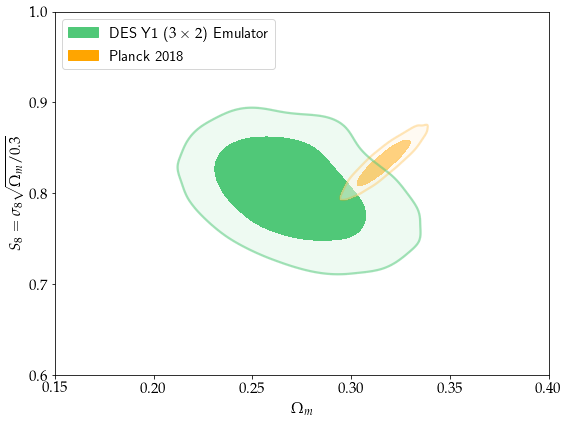

In [16]:
G = plots.getSinglePlotter(width_inch=8, ratio=0.75)
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1.0
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.solid_contour_palefactor = palefactor
G.settings.alpha_filled_add = alpha
G.settings.legend_fontsize = 15
G.plot_2d([samples_1, samples_2], 'x0', 'x1', filled=[True, True], colors =[color1, 'orange'], lims = [0.15, 0.4, 0.6, 1.0])
G.add_legend(legend_labels_, legend_loc='upper left');
# plt.savefig(f'plots/S8_OM_emu.pdf', bbox_inches = 'tight')
plt.show()

# Two Sets of Samples

In [17]:
# sampler_1 = pickle_load('samples', 'samples_emu_50_5000_1')
# sampler_2 = pickle_load('samples', 'samples_jaxcosmo_50_5000_2')
# flat_samples_1 = sampler_1.get_chain(discard=100, thin=2, flat=True) 
# flat_samples_2 = sampler_2.get_chain(discard=100, thin=2, flat=True) 

In [16]:
ndim = len(labels_cosmo)
names = ["x%s"%i for i in range(ndim)]

# samples_1 = MCSamples(samples=emu_cosmo_samples,names = names, labels = labels_cosmo, settings = settings, label = 'Emulator')
samples_1 = MCSamples(samples=ccl_cosmo,names = names, labels = labels_cosmo, settings = settings, label = 'CCL')
samples_2 = MCSamples(samples=jax_cosmo_samples,names = names, labels = labels_cosmo, settings = settings, label = 'JAX-COSMO')

Removed no burn in
Removed no burn in


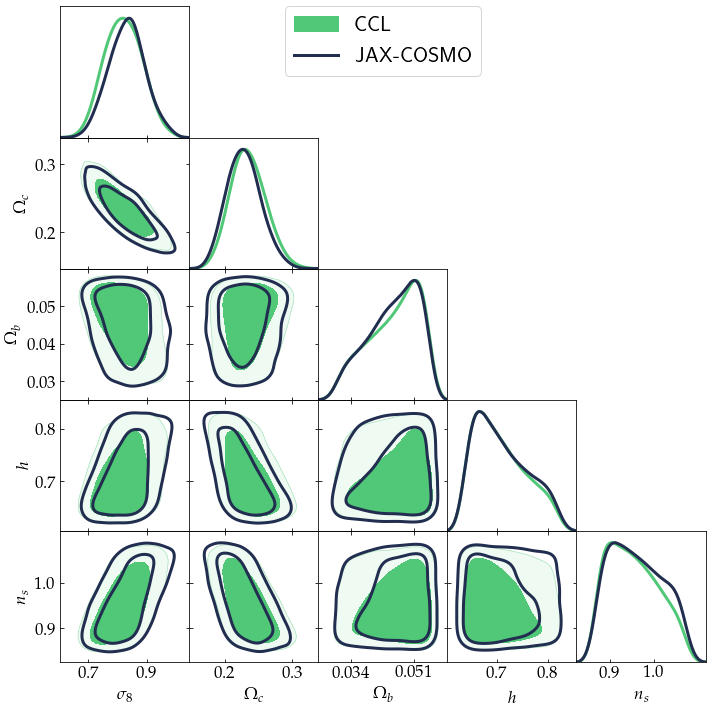

In [17]:
G = plots.getSubplotPlotter(subplot_size=2)
G.settings.solid_contour_palefactor = palefactor
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 20
G.settings.lab_fontsize = 20
G.settings.fontsize = 35 # important for padding in x-axis 
G.settings.legend_fontsize = 25
samples_1.updateSettings({'contours': [0.68, 0.95]})
samples_2.updateSettings({'contours': [0.68, 0.95]})
G.triangle_plot([samples_1, samples_2], filled = [True,False], contour_colors=[color1, color3], contour_lws=[3,3], contour_ls=['-', '-'])
# plt.savefig('plots/triangle_plot_comparison.pdf', transparent = False, bbox_inches = 'tight') 
plt.show()

# $\Omega_{m}$ vs $S_{8}$

In [20]:
# omega_matter_1 = flat_samples_1[:,1] + flat_samples_1[:,2]
# s8_parameter_1 = flat_samples_1[:,0] * np.sqrt(omega_matter_1/0.3)
# samples_om_s8_1 = np.c_[np.atleast_2d(omega_matter_1).T, np.atleast_2d(s8_parameter_1).T]

# omega_matter_2 = flat_samples_2[:,1] + flat_samples_2[:,2]
# s8_parameter_2 = flat_samples_2[:,0] * np.sqrt(omega_matter_2/0.3)
# samples_om_s8_2 = np.c_[np.atleast_2d(omega_matter_2).T, np.atleast_2d(s8_parameter_2).T]

In [21]:
omega_matter_1 = emu_cosmo_samples[:,1] + emu_cosmo_samples[:,2]
s8_parameter_1 = emu_cosmo_samples[:,0] * np.sqrt(omega_matter_1/0.3)
samples_om_s8_1 = np.c_[np.atleast_2d(omega_matter_1).T, np.atleast_2d(s8_parameter_1).T]

omega_matter_2 = jax_cosmo_samples[:,1] + jax_cosmo_samples[:,2]
s8_parameter_2 = jax_cosmo_samples[:,0] * np.sqrt(omega_matter_2/0.3)
samples_om_s8_2 = np.c_[np.atleast_2d(omega_matter_2).T, np.atleast_2d(s8_parameter_2).T]

In [22]:
names    = ["x%s"%i for i in range(2)]
labels   =  [r'$\Omega_{m}$', r'$S_{8}=\sigma_{8}\sqrt{\Omega_{m}/0.3}$']

In [23]:
samples_getdist_1 = MCSamples(samples=samples_om_s8_1,names = names, labels = labels, settings = settings)
samples_getdist_2 = MCSamples(samples=samples_om_s8_2,names = names, labels = labels, settings = settings)
samples_getdist_p = MCSamples(samples=samples_planck,names = names, labels = labels, settings = settings)

Removed no burn in
Removed no burn in
Removed no burn in


In [24]:
legend_labels_ = ['Emulator', 'JAX-COSMO', 'Planck 2018']

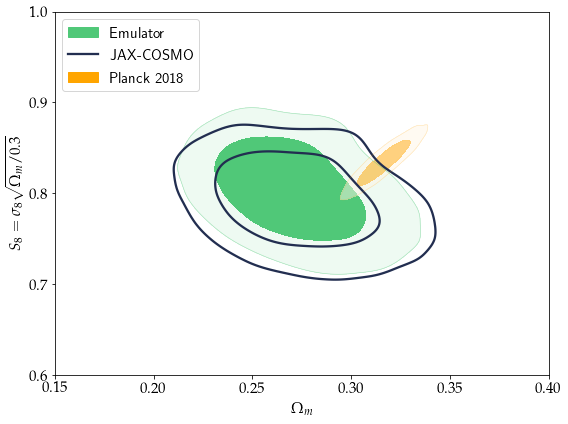

In [25]:
G = plots.getSinglePlotter(width_inch=8, ratio=0.75)
G.settings.num_plot_contours = 2
G.settings.lw_contour = 0.2
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = alpha
G.settings.legend_fontsize = 15
G.plot_2d([samples_getdist_1, samples_getdist_2, samples_getdist_p], 'x0', 'x1', filled=[True, False, True], colors =[color1, color3, 'orange'], lims = [0.15, 0.4, 0.6, 1.0])
G.add_legend(legend_labels_, legend_loc='upper left');
# plt.savefig(f'plots/S8_OM_comparison.pdf', bbox_inches = 'tight')
plt.show()

# Compare Samplers

In [28]:
ndim = len(labels_cosmo)
names = ["x%s"%i for i in range(ndim)]

samples_1 = MCSamples(samples=emu_cosmo_samples_nuts,names = names, labels = labels_cosmo, settings = settings, label = 'Emulator + JAX-COSMO + NUTS')
samples_2 = MCSamples(samples=emu_cosmo_samples,names = names, labels = labels_cosmo, settings = settings, label = 'Emulator + JAX-COSMO + EMCEE')

Removed no burn in
Removed no burn in


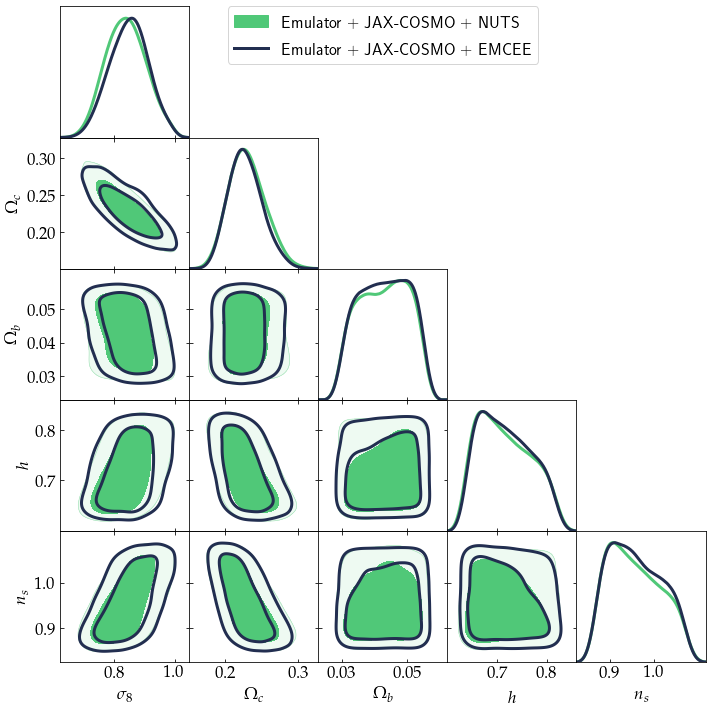

In [30]:
G = plots.getSubplotPlotter(subplot_size=2)
G.settings.solid_contour_palefactor = palefactor
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 20
G.settings.lab_fontsize = 20
G.settings.fontsize = 35 # important for padding in x-axis 
G.settings.legend_fontsize = 20
samples_1.updateSettings({'contours': [0.68, 0.95]})
samples_2.updateSettings({'contours': [0.68, 0.95]})
G.triangle_plot([samples_1, samples_2], filled = [True,False], contour_colors=[color1, color3], contour_lws=[3,3], contour_ls=['-', '-'])
# plt.savefig('plots/triangle_plot_comparison.pdf', transparent = False, bbox_inches = 'tight') 
plt.show()

In [31]:
samples_1 = MCSamples(samples=jax_cosmo_samples_nuts,names = names, labels = labels_cosmo, settings = settings, label = 'JAX-COSMO (NUTS)')
samples_2 = MCSamples(samples=jax_cosmo_samples,names = names, labels = labels_cosmo, settings = settings, label = 'JAX-COSMO (EMCEE)')

Removed no burn in
Removed no burn in


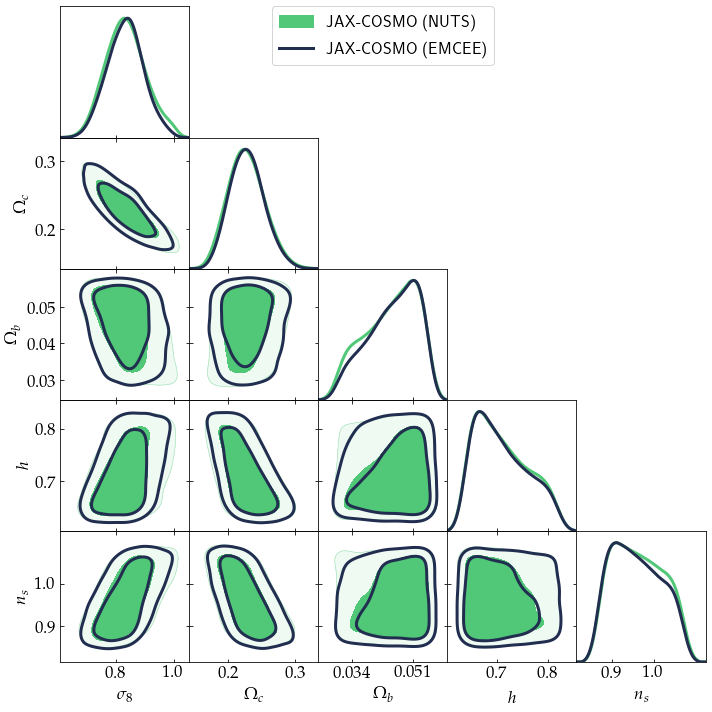

In [32]:
G = plots.getSubplotPlotter(subplot_size=2)
G.settings.solid_contour_palefactor = palefactor
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 20
G.settings.lab_fontsize = 20
G.settings.fontsize = 35 # important for padding in x-axis 
G.settings.legend_fontsize = 20
samples_1.updateSettings({'contours': [0.68, 0.95]})
samples_2.updateSettings({'contours': [0.68, 0.95]})
G.triangle_plot([samples_1, samples_2], filled = [True,False], contour_colors=[color1, color3], contour_lws=[3,3], contour_ls=['-', '-'])
# plt.savefig('plots/triangle_plot_comparison.pdf', transparent = False, bbox_inches = 'tight') 
plt.show()